## Project Name: - Financial Forecasting Frontier: Distributed ML
### Project Type: - Distributed Machine Learning
### Contribution: - Individual - Archit Dhodi

[Financial Forecasting using Distributed ML](https://github.com/ArchitDhodi/Financial-Forecasting-Frontier-Distributed-ML)

## Problem Statement: -
 The primary goal of this project is to demonstrate how distributed machine learning can transform banking data into actionable insights. Using the "bank.csv" dataset, i have to explore various aspects of distributed computing, from data storage and querying to predictive analytics and real-time data processing. The project aims to simulate a real-world banking data environment, offering insights into customer behavior, identifying key trends, and facilitating data-driven decision-making.

## Import libraries

In [2]:
import os
import sys
import time
import psutil
import threading
import random
from datetime import datetime, timedelta
from typing import List, Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation

In [3]:
!java -version

openjdk version "11.0.29" 2025-10-21 LTS
OpenJDK Runtime Environment Corretto-11.0.29.7.1 (build 11.0.29+7-LTS)
OpenJDK 64-Bit Server VM Corretto-11.0.29.7.1 (build 11.0.29+7-LTS, mixed mode)


In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = f"{os.environ['JAVA_HOME']}/bin:" + os.environ["PATH"]

In [ ]:
# Environment setup - run this FIRST, always

if 'JAVA_HOME' in os.environ:
    del os.environ['JAVA_HOME']

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'
os.environ['SPARK_LOCAL_HOSTNAME'] = 'localhost'

spark = SparkSession.builder \
    .appName("SparkProject") \
    .master("local[*]") \
    .config("spark.ui.enabled", "false") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.memory", "16g") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.sql.adaptive.localShuffleReader.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "256MB") \
    .config("spark.sql.adaptive.coalescePartitions.parallelismFirst", "false") \
    .config("spark.sql.files.maxPartitionBytes", "256MB") \
    .config("spark.default.parallelism", "16") \
    .getOrCreate()

print(f"Spark {spark.version} session created!")
print(f"Driver memory: 16GB")
print(f"Max result size: 8GB")
print(f"CPU cores: {spark.sparkContext.defaultParallelism}")

Spark 3.5.1 session created!
Driver memory: 16GB (out of your 48GB)
Max result size: 8GB
CPU cores: 16


In [7]:
def get_system_resources():
    print("Monitor system resources")
    cpu_percent = psutil.cpu_percent(interval=1)
    memory = psutil.virtual_memory()
    return {
        "cpu_percent": cpu_percent,
        "memory_percent": memory.percent,
        "memory_available_gb": memory.available / (1024**3),
        "memory_total_gb": memory.total / (1024**3)
    }

In [8]:
print("COMPLETE PYSPARK ANALYSIS - ALL 3 BATCHES")
print("="*80)
print("Batch 1: Basic PySpark Operations (5 questions)")
print("Batch 2: Data Analysis and Visualization (12 questions)")
print("Batch 3: Machine Learning Pipeline (7 questions)")
print("Total: 29 comprehensive questions")
print("="*80)

# ============================================================================
# BATCH 1: BASIC PYSPARK OPERATIONS (Questions 1-5)
# ============================================================================

print("\n\n" + "="*20 + " BATCH 1: BASIC PYSPARK OPERATIONS " + "="*20)

# ============================================================================
# BATCH 1 - QUESTION 1: DATA PREPARATION AND PARTITIONING
# ============================================================================

print("BATCH 1 - QUESTION 1: DATA PREPARATION AND PARTITIONING")
print("-"*80)
# Load the dataset
df = spark.read.csv("bank.csv", header=True, inferSchema=True)
print("Dataset loaded successfully!")
print(f"Total rows: {df.count()}")
print(f"Total columns: {len(df.columns)}")
print(f"Columns: {df.columns}")
print("First 5 rows:")
df.show(5, truncate=False)
print("Schema:")
df.printSchema()
print("Summary statistics:")

COMPLETE PYSPARK ANALYSIS - ALL 3 BATCHES
Batch 1: Basic PySpark Operations (5 questions)
Batch 2: Data Analysis and Visualization (12 questions)
Batch 3: Machine Learning Pipeline (7 questions)
Total: 29 comprehensive questions


==================== BATCH 1: BASIC PYSPARK OPERATIONS ====================
BATCH 1 - QUESTION 1: DATA PREPARATION AND PARTITIONING
--------------------------------------------------------------------------------
Dataset loaded successfully!
Total rows: 4521
Total columns: 17
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
First 5 rows:
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|job        |marital|education|default|balance|housing|loan|contact |day|month|duration|campaign|pdays|previous|poutcome|y  |
+---+-----------+-------+---------+-----

In [ ]:
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df.describe().show()

# Check current partitioning
print(f"\nCurrent number of partitions: {df.rdd.getNumPartitions()}")

# Partitioning strategies
optimal_partitions = spark.sparkContext.defaultParallelism
df_repartitioned = df.repartition(optimal_partitions)
print(f"Repartitioned to {optimal_partitions} partitions (based on available cores)")

df_partitioned_by_job = df.repartition(col("job"))
print(f"Partitioned by 'job' column: {df_partitioned_by_job.rdd.getNumPartitions()} partitions")

df_hash_partitioned = df.repartition(8, col("age"))
print(f"Hash partitioned by 'age': {df_hash_partitioned.rdd.getNumPartitions()} partitions")

print("\n Chosen Strategy: Hash Partitioning by 'age' for balanced distribution")

# Use hash partitioned version
df = df_hash_partitioned

print("\n Question 1 completed!")

+-------+------------------+-------+--------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+----+
|summary|               age|    job| marital|education|default|           balance|housing|loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|   y|
+-------+------------------+-------+--------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+----+
|  count|              4521|   4521|    4521|     4521|   4521|              4521|   4521|4521|    4521|              4521| 4521|              4521|              4521|              4521|              4521|    4521|4521|
|   mean| 41.17009511170095|   NULL|    NULL|     NULL|   NULL|1422.6578190665782|   NULL|NULL|    NULL|15.9152842291528

In [10]:
# ============================================================================
# BATCH 1 - QUESTION 2: DATA ANALYSIS AND PROCESSING IN PARALLEL
# ============================================================================

print("BATCH 1 - QUESTION 2: DATA ANALYSIS AND PROCESSING IN PARALLEL")
print("-"*80)

# Calculate average balance by job category
print(" Average balance by job category:")
start_time = time.time()

job_stats = df.groupBy("job").agg(avg("balance").alias("avg_balance"),avg("duration").alias("avg_duration"),count("*").alias("customer_count"),
                                  stddev("balance").alias("balance_stddev")).orderBy(desc("avg_balance"))

job_stats.cache()
job_stats.show(truncate=False)

processing_time = time.time() - start_time
print(f" Processing time: {processing_time:.2f} seconds")

# Top 5 age groups with highest loan amounts
print("\n Top 5 age groups with highest loan amounts:")
start_time = time.time()

df_with_age_groups = df.withColumn(
    "age_group",
    when(col("age") < 25, "18-24")
    .when(col("age") < 35, "25-34")
    .when(col("age") < 45, "35-44")
    .when(col("age") < 55, "45-54")
    .when(col("age") < 65, "55-64")
    .otherwise("65+")
)

age_group_loans = df_with_age_groups \
    .filter(col("loan") == "yes") \
    .groupBy("age_group") \
    .agg(
        count("*").alias("loan_count"),
        sum("balance").alias("total_loan_amount"),
        avg("balance").alias("avg_loan_amount"),
        avg("duration").alias("avg_call_duration")
    ) \
    .orderBy(desc("total_loan_amount")) \
    .limit(5)

age_group_loans.show(truncate=False)

processing_time = time.time() - start_time
print(f" Processing time: {processing_time:.2f} seconds")

print("\n Question 2 completed!")

BATCH 1 - QUESTION 2: DATA ANALYSIS AND PROCESSING IN PARALLEL
--------------------------------------------------------------------------------
 Average balance by job category:
+-------------+------------------+------------------+--------------+------------------+
|job          |avg_balance       |avg_duration      |customer_count|balance_stddev    |
+-------------+------------------+------------------+--------------+------------------+
|retired      |2319.191304347826 |285.6565217391304 |230           |5846.379888960141 |
|housemaid    |2083.8035714285716|292.63392857142856|112           |4603.83664686076  |
|management   |1766.9287925696594|260.53663570691435|969           |3267.733077374219 |
|entrepreneur |1645.125          |285.4761904761905 |168           |4441.303620172446 |
|student      |1543.8214285714287|248.6904761904762 |84            |2579.886670531924 |
|unknown      |1501.7105263157894|216.92105263157896|38            |1957.2582575922956|
|self-employed|1392.4098360655

In [11]:
# ============================================================================
# BATCH 1 - QUESTION 3: MODEL TRAINING ON PARTITIONED DATA
# ============================================================================

print("\nBATCH 1 - QUESTION 3: MODEL TRAINING ON PARTITIONED DATA")
print("-"*80)

print(" Model Selection: Random Forest Classifier")
print(" Reasons: Handles mixed data types, good performance, parallel training")

# Feature engineering for basic model
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']
numerical_cols_basic = ['age', 'balance', 'duration', 'campaign']

# String indexers
indexers = []
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_idx")
    indexers.append(indexer)

# Target indexer
label_indexer = StringIndexer(inputCol="y", outputCol="label")

# Feature assembler
feature_cols = [f"{col}_idx" for col in categorical_cols] + numerical_cols_basic
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)

# Pipeline
pipeline = Pipeline(stages=indexers + [label_indexer, assembler, rf])

# Split data
print(" Splitting data:")
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
print(f"Training: {train_data.count()} rows")
print(f"Testing: {test_data.count()} rows")

# Train model
print(" Training model...")
start_time = time.time()
model = pipeline.fit(train_data)
training_time = time.time() - start_time
print(f" Training completed in {training_time:.2f} seconds")

# Evaluate
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions)
print(f" Model AUC: {auc:.4f}")

print(" Question 3 completed!")


BATCH 1 - QUESTION 3: MODEL TRAINING ON PARTITIONED DATA
--------------------------------------------------------------------------------
 Model Selection: Random Forest Classifier
 Reasons: Handles mixed data types, good performance, parallel training
 Splitting data:
Training: 3620 rows
Testing: 901 rows
 Training model...
 Training completed in 5.67 seconds
 Model AUC: 0.8152
 Question 3 completed!


In [12]:
# ============================================================================
# BATCH 1 - QUESTION 4: RESOURCE MONITORING AND MANAGEMENT
# ============================================================================

print("\n BATCH 1 - QUESTION 4: RESOURCE MONITORING AND MANAGEMENT")
print("-"*80)

print(" System Resource Monitoring:")

# Monitor during data loading
print("\n During data loading:")
cpu_before, mem_before = get_system_resources()['cpu_percent'], get_system_resources()['memory_percent']
df_test = spark.read.csv("bank.csv", header=True, inferSchema=True)
df_test.count()
cpu_after, mem_after = get_system_resources()['cpu_percent'], get_system_resources()['memory_percent']
print(f"   CPU: {cpu_before:.1f}%  {cpu_after:.1f}%")
print(f"   Memory: {mem_before:.1f}%  {mem_after:.1f}%")

# Monitor during aggregation
print("\n During aggregation:")
cpu_before, mem_before = get_system_resources()['cpu_percent'], get_system_resources()['memory_percent']
result = df.groupBy("job").count().collect()
cpu_after, mem_after = get_system_resources()['cpu_percent'], get_system_resources()['memory_percent']
print(f"   CPU: {cpu_before:.1f}%  {cpu_after:.1f}%")
print(f"   Memory: {mem_before:.1f}%  {mem_after:.1f}%")

print(f"\n Spark UI: http://localhost:4040")
print(f" App ID: {spark.sparkContext.applicationId}")

print("\n Question 4 completed!")


 BATCH 1 - QUESTION 4: RESOURCE MONITORING AND MANAGEMENT
--------------------------------------------------------------------------------
 System Resource Monitoring:

 During data loading:
Monitor system resources
Monitor system resources
Monitor system resources
Monitor system resources
   CPU: 6.5%  7.4%
   Memory: 33.0%  33.0%

 During aggregation:
Monitor system resources
Monitor system resources
Monitor system resources
Monitor system resources
   CPU: 8.2%  7.9%
   Memory: 33.0%  33.0%

 Spark UI: http://localhost:4040
 App ID: local-1766907063686

 Question 4 completed!


In [ ]:
# ============================================================================
# BATCH 1 - QUESTION 5: TASK MANAGEMENT AND SCHEDULING
# ============================================================================

print("\n BATCH 1 - QUESTION 5: TASK MANAGEMENT AND SCHEDULING")
print("-"*80)

print(" Managing Multiple Parallel Tasks:")

# Task 1: Data cleaning
print("\n Task 1: Data Cleaning")
start_time = time.time()
clean_df = df.filter(col("age") > 0) \
    .filter(col("balance").isNotNull()) \
    .dropDuplicates()
clean_count = clean_df.count()
task1_time = time.time() - start_time
print(f"    Cleaned {clean_count} records in {task1_time:.2f}s")

# Task 2: Feature engineering
print("\n Task 2: Feature Engineering")
start_time = time.time()
feature_df = clean_df \
    .withColumn("age_category", when(col("age") < 40, "Young").otherwise("Older")) \
    .withColumn("high_balance", when(col("balance") > 1000, 1).otherwise(0)) \
    .withColumn("long_call", when(col("duration") > 300, 1).otherwise(0))
feature_df.cache()
feature_count = feature_df.count()
task2_time = time.time() - start_time
print(f"    Engineered features for {feature_count} records in {task2_time:.2f}s")

# Task 3: Statistical analysis
print("\n Task 3: Statistical Analysis")
start_time = time.time()
stats = feature_df.describe(['age', 'balance', 'duration']).collect()
job_stats_task = feature_df.groupBy("job").count().collect()
task3_time = time.time() - start_time
print(f"    Computed statistics in {task3_time:.2f}s")

# Task 4: Data validation
print("\n Task 4: Data Validation")
start_time = time.time()
validation_results = {
    'total_records': feature_df.count(),
    'null_values': feature_df.filter(col("age").isNull()).count(),
    'negative_balance': feature_df.filter(col("balance") < 0).count()
}
task4_time = time.time() - start_time
print(f"    Validated data in {task4_time:.2f}s")

print(f"\n Task Execution Summary:")
total_time = task1_time + task2_time + task3_time + task4_time
print(f"   Total Time: {total_time:.2f}s")

print(" Question 5 completed!")

print("\n BATCH 1 COMPLETED! Moving to Batch 2...")


 BATCH 1 - QUESTION 5: TASK MANAGEMENT AND SCHEDULING
--------------------------------------------------------------------------------
 Managing Multiple Parallel Tasks:

 Task 1: Data Cleaning
    Cleaned 4521 records in 0.30s

 Task 2: Feature Engineering
    Engineered features for 4521 records in 0.31s

 Task 3: Statistical Analysis
    Computed statistics in 0.41s

 Task 4: Data Validation
    Validated data in 0.28s

 Task Execution Summary:
   Total Time: 1.30s
 Question 5 completed!

 BATCH 1 COMPLETED! Moving to Batch 2...


In [14]:
# ============================================================================
# BATCH 2: DATA ANALYSIS AND VISUALIZATION (Questions 6-17)
# ============================================================================

print("\n\n" + "="*20 + " BATCH 2: DATA ANALYSIS AND VISUALIZATION " + "="*20)

# Use the clean dataframe from previous batch
df_analysis = feature_df

# ============================================================================
# BATCH 2 - QUESTION 6: DATA LOADING AND BASIC INSPECTION
# ============================================================================

print("\n BATCH 2 - QUESTION 6: DATA LOADING AND BASIC INSPECTION")
print("-"*80)

print(" Extended Dataset Analysis:")
print(f"Cleaned dataset: {df_analysis.count()} rows, {len(df_analysis.columns)} columns")

print("\n Extended schema with engineered features:")
df_analysis.printSchema()

print("\n Summary of all numerical columns:")
all_numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
df_analysis.select(all_numerical).describe().show()

# Categorical analysis
categorical_cols_extended = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
print("\n Categorical distributions:")
for col_name in categorical_cols_extended[:3]:  # Show first 3 to save space
    print(f"\n{col_name.upper()}:")
    df_analysis.groupBy(col_name).count().orderBy(desc("count")).show(5)

print("\n Question 6 completed!")



==================== BATCH 2: DATA ANALYSIS AND VISUALIZATION ====================

 BATCH 2 - QUESTION 6: DATA LOADING AND BASIC INSPECTION
--------------------------------------------------------------------------------
 Extended Dataset Analysis:
Cleaned dataset: 4521 rows, 20 columns

 Extended schema with engineered features:
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- age_

In [15]:
# ============================================================================
# BATCH 2 - QUESTION 7: DATA FILTERING AND COLUMN OPERATIONS
# ============================================================================

print("\n BATCH 2 - QUESTION 7: DATA FILTERING AND COLUMN OPERATIONS")
print("-"*80)

# Filter clients with balance > 1000
threshold = 1000
df_filtered = df_analysis.filter(col("balance") > threshold)
print(f" Clients with balance > {threshold}: {df_filtered.count()} out of {df_analysis.count()}")

# Create quarter column from month
df_with_quarter = df_analysis.withColumn(
    "quarter",
    when(col("month").isin("jan", "feb", "mar"), "Q1")
    .when(col("month").isin("apr", "may", "jun"), "Q2")
    .when(col("month").isin("jul", "aug", "sep"), "Q3")
    .when(col("month").isin("oct", "nov", "dec"), "Q4")
    .otherwise("Unknown")
)

print("\n Quarter distribution:")
df_with_quarter.groupBy("quarter").count().orderBy("quarter").show()

print("\n Question 7 completed!")


 BATCH 2 - QUESTION 7: DATA FILTERING AND COLUMN OPERATIONS
--------------------------------------------------------------------------------
 Clients with balance > 1000: 1481 out of 4521

 Quarter distribution:
+-------+-----+
|quarter|count|
+-------+-----+
|     Q1|  419|
|     Q2| 2222|
|     Q3| 1391|
|     Q4|  489|
+-------+-----+


 Question 7 completed!


In [16]:
# ============================================================================
# BATCH 2 - QUESTION 8: GROUPBY AND AGGREGATION
# ============================================================================

print("\n BATCH 2 - QUESTION 8: GROUPBY AND AGGREGATION")
print("-"*80)

# Average balance and median age by job type
print(" Average balance and median age by job:")
job_detailed_stats = df_analysis.groupBy("job") \
    .agg(
        avg("balance").alias("avg_balance"),
        expr("percentile_approx(age, 0.5)").alias("median_age"),
        count("*").alias("total_clients"),
        stddev("balance").alias("balance_stddev")
    ) \
    .orderBy(desc("avg_balance"))

job_detailed_stats.show(truncate=False)

# Subscription count by marital status
print("\n Subscriptions by marital status:")
marital_subscriptions = df_analysis.filter(col("y") == "yes") \
    .groupBy("marital") \
    .count() \
    .withColumnRenamed("count", "subscriptions") \
    .orderBy(desc("subscriptions"))

marital_subscriptions.show()

print("\n Question 8 completed!")


 BATCH 2 - QUESTION 8: GROUPBY AND AGGREGATION
--------------------------------------------------------------------------------
 Average balance and median age by job:
+-------------+------------------+----------+-------------+------------------+
|job          |avg_balance       |median_age|total_clients|balance_stddev    |
+-------------+------------------+----------+-------------+------------------+
|retired      |2319.191304347826 |59        |230          |5846.379888960141 |
|housemaid    |2083.8035714285716|49        |112          |4603.83664686076  |
|management   |1766.9287925696594|38        |969          |3267.733077374219 |
|entrepreneur |1645.125          |41        |168          |4441.303620172446 |
|student      |1543.8214285714287|26        |84           |2579.886670531924 |
|unknown      |1501.7105263157894|49        |38           |1957.2582575922956|
|self-employed|1392.4098360655737|40        |183          |2479.6409992088907|
|technician   |1330.99609375     |38     

In [ ]:
# ============================================================================
# BATCH 2 - QUESTION 9: UDF TO CATEGORIZE AGE GROUPS
# ============================================================================

print("\n BATCH 2 - QUESTION 9: UDF TO CATEGORIZE AGE GROUPS")
print("-"*80)

# Define UDF for age categorization
def categorize_age(age):
    if age < 30:
        return "<30"
    elif age <= 60:
        return "30-60"
    else:
        return ">60"

# Register UDF
age_categorize_udf = udf(categorize_age, StringType())

# Apply UDF
df_with_age_group = df_analysis.withColumn("age_group_udf", age_categorize_udf(col("age")))

print(" Age group distribution (UDF):")
df_with_age_group.groupBy("age_group_udf").count().orderBy("age_group_udf").show()

print(" Age groups with subscription analysis:")
age_group_analysis = df_with_age_group.groupBy("age_group_udf") \
    .agg(
        count("*").alias("total"),
        sum(when(col("y") == "yes", 1).otherwise(0)).alias("subscriptions"),
        avg("balance").alias("avg_balance")
    ) \
    .withColumn("subscription_rate", 
               round((col("subscriptions") * 100.0 / col("total")), 2))

age_group_analysis.show()

print("\n Question 9 completed!")


 BATCH 2 - QUESTION 9: UDF TO CATEGORIZE AGE GROUPS
--------------------------------------------------------------------------------
 Age group distribution (UDF):
+-------------+-----+
|age_group_udf|count|
+-------------+-----+
|        30-60| 3912|
|          <30|  482|
|          >60|  127|
+-------------+-----+

 Age groups with subscription analysis:
+-------------+-----+-------------+------------------+-----------------+
|age_group_udf|total|subscriptions|       avg_balance|subscription_rate|
+-------------+-----+-------------+------------------+-----------------+
|          >60|  127|           48|2676.3543307086616|             37.8|
|        30-60| 3912|          399|1426.8755112474437|             10.2|
|          <30|  482|           74|1058.0954356846473|            15.35|
+-------------+-----+-------------+------------------+-----------------+


 Question 9 completed!


In [18]:
# ============================================================================
# BATCH 2 - QUESTION 10: ADVANCED DATA TRANSFORMATIONS
# ============================================================================

print("\n BATCH 2 - QUESTION 10: ADVANCED DATA TRANSFORMATIONS")
print("-"*80)

# Subscription rate by education level
print(" Subscription rate by education level:")
education_analysis = df_analysis.groupBy("education") \
    .agg(
        count("*").alias("total_clients"),
        sum(when(col("y") == "yes", 1).otherwise(0)).alias("subscriptions")
    ) \
    .withColumn("subscription_rate", 
               round((col("subscriptions") * 100.0 / col("total_clients")), 2)) \
    .orderBy(desc("subscription_rate"))

education_analysis.show()

# Top 3 professions with highest loan default rate
print("\n Top 3 professions with highest default rate:")
default_analysis = df_analysis.groupBy("job") \
    .agg(
        count("*").alias("total"),
        sum(when(col("default") == "yes", 1).otherwise(0)).alias("defaults")
    ) \
    .withColumn("default_rate", 
               round((col("defaults") * 100.0 / col("total")), 2)) \
    .filter(col("total") > 10) \
    .orderBy(desc("default_rate")) \
    .limit(3)

default_analysis.show()

print("\n Question 10 completed!")


 BATCH 2 - QUESTION 10: ADVANCED DATA TRANSFORMATIONS
--------------------------------------------------------------------------------
 Subscription rate by education level:
+---------+-------------+-------------+-----------------+
|education|total_clients|subscriptions|subscription_rate|
+---------+-------------+-------------+-----------------+
| tertiary|         1350|          193|             14.3|
|secondary|         2306|          245|            10.62|
|  unknown|          187|           19|            10.16|
|  primary|          678|           64|             9.44|
+---------+-------------+-------------+-----------------+


 Top 3 professions with highest default rate:
+-------------+-----+--------+------------+
|          job|total|defaults|default_rate|
+-------------+-----+--------+------------+
| entrepreneur|  168|       7|        4.17|
|   unemployed|  128|       3|        2.34|
|self-employed|  183|       4|        2.19|
+-------------+-----+--------+------------+


 Qu

In [19]:
# ============================================================================
# BATCH 2 - QUESTION 11: STRING MANIPULATION AND DATE FUNCTIONS
# ============================================================================

print("\n BATCH 2 - QUESTION 11: STRING MANIPULATION")
print("-"*80)

# Concatenate job and marital columns
df_string_ops = df_analysis.withColumn(
    "job_marital", 
    concat(col("job"), lit("_"), col("marital"))
)

print(" Sample job_marital combinations:")
df_string_ops.select("job", "marital", "job_marital").distinct().show(10)

# Convert contact column to uppercase
df_string_ops = df_string_ops.withColumn("contact_upper", upper(col("contact")))

print("\n Contact methods (uppercase):")
df_string_ops.select("contact", "contact_upper").distinct().show()

print("\n Question 11 completed!")


 BATCH 2 - QUESTION 11: STRING MANIPULATION
--------------------------------------------------------------------------------
 Sample job_marital combinations:
+-------------+--------+--------------------+
|          job| marital|         job_marital|
+-------------+--------+--------------------+
|   management| married|  management_married|
|self-employed|  single|self-employed_single|
|   unemployed|divorced| unemployed_divorced|
|self-employed|divorced|self-employed_div...|
|   technician|divorced| technician_divorced|
|    housemaid| married|   housemaid_married|
|     services| married|    services_married|
|  blue-collar| married| blue-collar_married|
| entrepreneur| married|entrepreneur_married|
|   unemployed|  single|   unemployed_single|
+-------------+--------+--------------------+
only showing top 10 rows


 Contact methods (uppercase):
+---------+-------------+
|  contact|contact_upper|
+---------+-------------+
|telephone|    TELEPHONE|
|  unknown|      UNKNOWN|
| cellula


 BATCH 2 - QUESTION 12: DATA VISUALIZATION
--------------------------------------------------------------------------------
 Creating visualizations...


c:\Users\archi\anaconda3\envs\spark_env\lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
c:\Users\archi\anaconda3\envs\spark_env\lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
c:\Users\archi\anaconda3\envs\spark_env\lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimiza

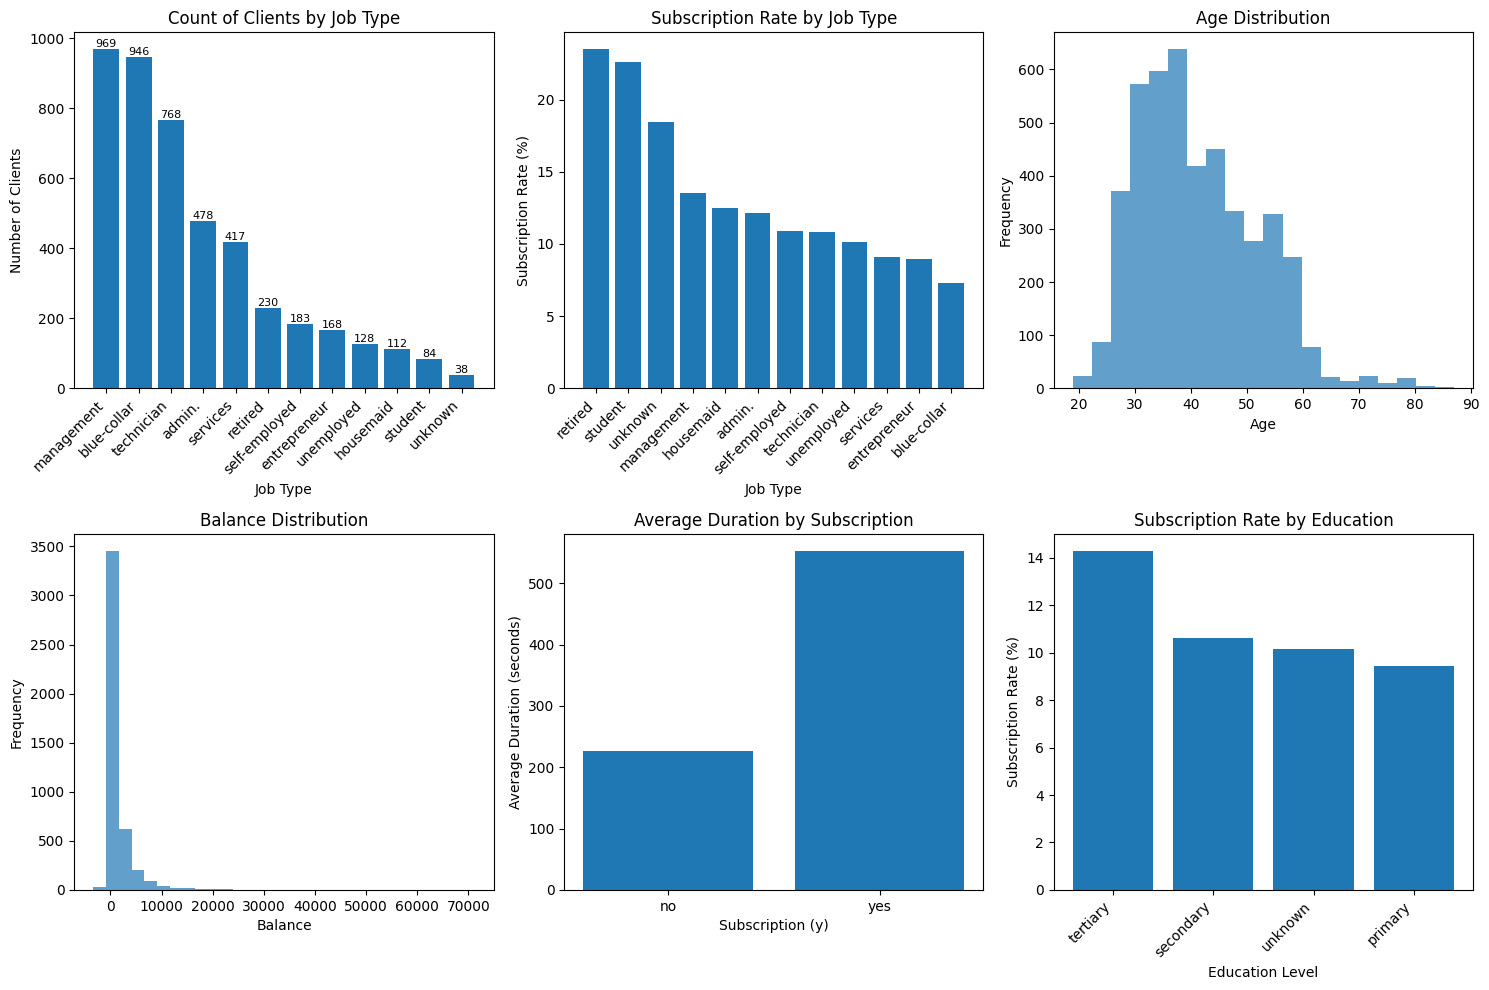


 Question 12 completed!


In [20]:
# ============================================================================
# BATCH 2 - QUESTION 12: DATA VISUALIZATION
# ============================================================================

print("\n BATCH 2 - QUESTION 12: DATA VISUALIZATION")
print("-"*80)

print(" Creating visualizations...")

# Convert to Pandas for visualization
job_counts = df_analysis.groupBy("job").count().orderBy(desc("count")).toPandas()

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Job counts
plt.subplot(2, 3, 1)
bars = plt.bar(job_counts['job'], job_counts['count'])
plt.title('Count of Clients by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Plot 2: Subscription rates by job
job_subscription = df_analysis.groupBy("job") \
    .agg(
        count("*").alias("total"),
        sum(when(col("y") == "yes", 1).otherwise(0)).alias("subs")
    ) \
    .withColumn("rate", col("subs") * 100.0 / col("total")) \
    .orderBy(desc("rate")) \
    .toPandas()

plt.subplot(2, 3, 2)
bars2 = plt.bar(job_subscription['job'], job_subscription['rate'])
plt.title('Subscription Rate by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Subscription Rate (%)')
plt.xticks(rotation=45, ha='right')

# Plot 3: Age distribution
age_dist = df_analysis.select("age").toPandas()
plt.subplot(2, 3, 3)
plt.hist(age_dist['age'], bins=20, alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Plot 4: Balance distribution
balance_dist = df_analysis.select("balance").toPandas()
plt.subplot(2, 3, 4)
plt.hist(balance_dist['balance'], bins=30, alpha=0.7)
plt.title('Balance Distribution')
plt.xlabel('Balance')
plt.ylabel('Frequency')

# Plot 5: Duration vs Subscription
duration_sub = df_analysis.groupBy("y") \
    .agg(avg("duration").alias("avg_duration")) \
    .toPandas()

plt.subplot(2, 3, 5)
bars3 = plt.bar(duration_sub['y'], duration_sub['avg_duration'])
plt.title('Average Duration by Subscription')
plt.xlabel('Subscription (y)')
plt.ylabel('Average Duration (seconds)')

# Plot 6: Education vs Subscription Rate
edu_sub = education_analysis.toPandas()
plt.subplot(2, 3, 6)
bars4 = plt.bar(edu_sub['education'], edu_sub['subscription_rate'])
plt.title('Subscription Rate by Education')
plt.xlabel('Education Level')
plt.ylabel('Subscription Rate (%)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n Question 12 completed!")

In [21]:
# ============================================================================
# BATCH 2 - QUESTION 13: COMPLEX QUERIES FOR INSIGHTS
# ============================================================================

print("\n\n13 BATCH 2 - QUESTION 13: COMPLEX QUERIES FOR INSIGHTS")
print("-"*80)

# Month with highest number of contacts
print(" Contacts by month:")
monthly_contacts = df_analysis.groupBy("month") \
    .agg(
        count("*").alias("total_contacts"),
        sum(when(col("y") == "yes", 1).otherwise(0)).alias("successful")
    ) \
    .withColumn("success_rate", 
               round((col("successful") * 100.0 / col("total_contacts")), 2)) \
    .orderBy(desc("total_contacts"))

monthly_contacts.show()

highest_contact_month = monthly_contacts.first()
print(f" Highest contact month: {highest_contact_month['month']}")
print(f"   Contacts: {highest_contact_month['total_contacts']}")
print(f"   Success rate: {highest_contact_month['success_rate']}%")

# Average duration: subscribers vs non-subscribers
print("\n Average contact duration analysis:")
duration_analysis = df_analysis.groupBy("y") \
    .agg(
        avg("duration").alias("avg_duration"),
        count("*").alias("count"),
        stddev("duration").alias("stddev_duration")
    )

duration_analysis.show()

print("\n Question 13 completed!")



13 BATCH 2 - QUESTION 13: COMPLEX QUERIES FOR INSIGHTS
--------------------------------------------------------------------------------
 Contacts by month:
+-----+--------------+----------+------------+
|month|total_contacts|successful|success_rate|
+-----+--------------+----------+------------+
|  may|          1398|        93|        6.65|
|  jul|           706|        61|        8.64|
|  aug|           633|        79|       12.48|
|  jun|           531|        55|       10.36|
|  nov|           389|        39|       10.03|
|  apr|           293|        56|       19.11|
|  feb|           222|        38|       17.12|
|  jan|           148|        16|       10.81|
|  oct|            80|        37|       46.25|
|  sep|            52|        17|       32.69|
|  mar|            49|        21|       42.86|
|  dec|            20|         9|        45.0|
+-----+--------------+----------+------------+

 Highest contact month: may
   Contacts: 1398
   Success rate: 6.65%

 Average contact du

In [22]:
# ============================================================================
# BATCH 2 - QUESTION 14: CORRELATION BETWEEN AGE AND BALANCE
# ============================================================================

print("\n BATCH 2 - QUESTION 14: CORRELATION BETWEEN AGE AND BALANCE")
print("-"*80)

# Calculate correlation coefficient
correlation = df_analysis.stat.corr("age", "balance")
print(f" Correlation between age and balance: {correlation:.4f}")

# Interpretation without abs()
if correlation < -0.5 or correlation > 0.5:
    interpretation = "Strong correlation"
elif correlation < -0.3 or correlation > 0.3:
    interpretation = "Moderate correlation"
elif correlation < -0.1 or correlation > 0.1:
    interpretation = "Weak correlation"
else:
    interpretation = "Very weak correlation"

print(f" Interpretation: {interpretation}")
print("\n Question 14 completed!")


 BATCH 2 - QUESTION 14: CORRELATION BETWEEN AGE AND BALANCE
--------------------------------------------------------------------------------
 Correlation between age and balance: 0.0838
 Interpretation: Very weak correlation

 Question 14 completed!



 BATCH 2 - QUESTION 15: EXPLORING LOAN DEFAULTS
--------------------------------------------------------------------------------
 Credit default analysis:
+-------+-----+-------------------+------------------+------------------+
|default|count|        avg_balance|           avg_age|      avg_duration|
+-------+-----+-------------------+------------------+------------------+
|     no| 4445| 1450.5509561304837| 41.19482564679415|264.35590551181105|
|    yes|   76|-208.72368421052633|39.723684210526315| 240.8815789473684|
+-------+-----+-------------------+------------------+------------------+


 Default proportions:
   no: 4445 clients (98.32%)
   yes: 76 clients (1.68%)


c:\Users\archi\anaconda3\envs\spark_env\lib\site-packages\pyspark\sql\pandas\conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


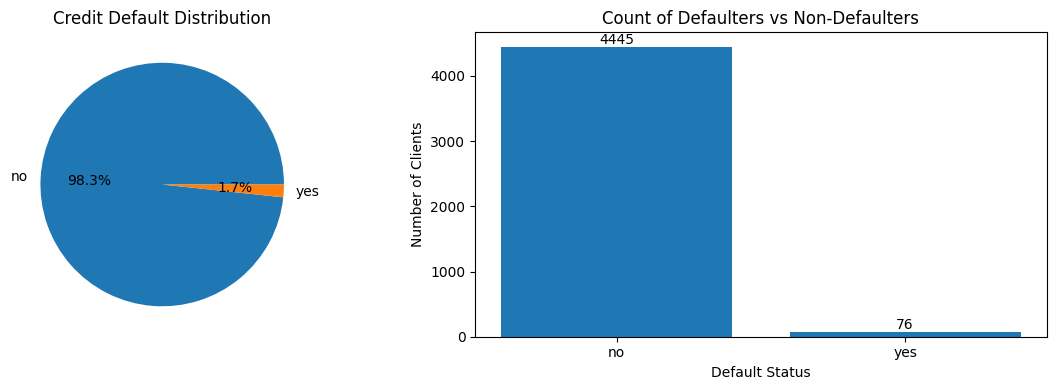


 Question 15 completed!


In [23]:
# ============================================================================
# BATCH 2 - QUESTION 15: EXPLORING LOAN DEFAULTS
# ============================================================================

print("\n BATCH 2 - QUESTION 15: EXPLORING LOAN DEFAULTS")
print("-"*80)

# Analyze defaults
print(" Credit default analysis:")
default_detailed = df_analysis.groupBy("default") \
    .agg(
        count("*").alias("count"),
        avg("balance").alias("avg_balance"),
        avg("age").alias("avg_age"),
        avg("duration").alias("avg_duration")
    )

default_detailed.show()

# Proportion analysis
total_clients = df_analysis.count()
default_counts = df_analysis.groupBy("default").count().collect()

print("\n Default proportions:")
for row in default_counts:
    proportion = (row['count'] / total_clients) * 100
    print(f"   {row['default']}: {row['count']} clients ({proportion:.2f}%)")

# Create default visualization
default_pandas = df_analysis.groupBy("default").count().toPandas()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.pie(default_pandas['count'], labels=default_pandas['default'], autopct='%1.1f%%')
plt.title('Credit Default Distribution')

plt.subplot(1, 2, 2)
bars = plt.bar(default_pandas['default'], default_pandas['count'])
plt.title('Count of Defaulters vs Non-Defaulters')
plt.xlabel('Default Status')
plt.ylabel('Number of Clients')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n Question 15 completed!")

In [24]:
# ============================================================================
# BATCH 2 - QUESTION 16: CONTACT METHOD ANALYSIS
# ============================================================================

print("\n BATCH 2 - QUESTION 16: CONTACT METHOD ANALYSIS")
print("-"*80)

# Analyze success rates by contact method
print(" Contact method effectiveness:")
contact_analysis = df_analysis.groupBy("contact") \
    .agg(
        count("*").alias("total_contacts"),
        sum(when(col("y") == "yes", 1).otherwise(0)).alias("successful"),
        avg("duration").alias("avg_duration")
    ) \
    .withColumn("success_rate", 
               round((col("successful") * 100.0 / col("total_contacts")), 2)) \
    .orderBy(desc("success_rate"))

contact_analysis.show()


 BATCH 2 - QUESTION 16: CONTACT METHOD ANALYSIS
--------------------------------------------------------------------------------
 Contact method effectiveness:
+---------+--------------+----------+------------------+------------+
|  contact|total_contacts|successful|      avg_duration|success_rate|
+---------+--------------+----------+------------------+------------+
|telephone|           301|        44|243.35548172757476|       14.62|
| cellular|          2896|       416|267.11256906077347|       14.36|
|  unknown|          1324|        61| 261.7530211480362|        4.61|
+---------+--------------+----------+------------------+------------+



In [25]:
# Find best contact method
best_contact = contact_analysis.first()
print(f" Best contact method: {best_contact['contact']}")
print(f"   Success rate: {best_contact['success_rate']}%")
print(f"   Average duration: {best_contact['avg_duration']:.2f} seconds")

# Cross-analysis: contact method vs job type
print("\n Contact method by job type (top combinations):")
contact_job_analysis = df_analysis.groupBy("contact", "job") \
    .agg(
        count("*").alias("contacts"),
        sum(when(col("y") == "yes", 1).otherwise(0)).alias("success")
    ) \
    .withColumn("success_rate", 
               round((col("success") * 100.0 / col("contacts")), 2)) \
    .filter(col("contacts") > 5) \
    .orderBy(desc("success_rate")) \
    .limit(10)

contact_job_analysis.show()

print("\n Question 16 completed!")

 Best contact method: telephone
   Success rate: 14.62%
   Average duration: 243.36 seconds

 Contact method by job type (top combinations):
+---------+------------+--------+-------+------------+
|  contact|         job|contacts|success|success_rate|
+---------+------------+--------+-------+------------+
|telephone|     retired|      42|     18|       42.86|
| cellular|     student|      62|     18|       29.03|
| cellular|     unknown|      24|      6|        25.0|
| cellular|     retired|     145|     29|        20.0|
|telephone|  management|      51|      9|       17.65|
|  unknown|     retired|      43|      7|       16.28|
| cellular|  management|     711|    115|       16.17|
|telephone|      admin.|      31|      5|       16.13|
|telephone|entrepreneur|      13|      2|       15.38|
| cellular|  unemployed|      85|     13|       15.29|
+---------+------------+--------+-------+------------+


 Question 16 completed!


In [26]:
# ============================================================================
# BATCH 2 - QUESTION 17: DATA PROCESSING WITH SPARK SQL
# ============================================================================

print("\n BATCH 2 - QUESTION 17: DATA PROCESSING WITH SPARK SQL")
print("-"*80)

# Create temporary view
df_with_age_group.createOrReplaceTempView("bank_data")

print(" Using Spark SQL for analysis:")

# Query 1: Average balance by age groups
print("\n Average account balance by age groups:")
age_balance_sql = spark.sql("""
    SELECT 
        age_group_udf as age_group,
        COUNT(*) as client_count,
        ROUND(AVG(balance), 2) as avg_balance,
        ROUND(STDDEV(balance), 2) as stddev_balance,
        MIN(balance) as min_balance,
        MAX(balance) as max_balance
    FROM bank_data 
    GROUP BY age_group_udf 
    ORDER BY age_group_udf
""")

age_balance_sql.show()

# Query 2: Most common job types
print("\n Most common job types:")
job_types_sql = spark.sql("""
    SELECT 
        job,
        COUNT(*) as client_count,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM bank_data), 2) as percentage
    FROM bank_data 
    GROUP BY job 
    ORDER BY client_count DESC
    LIMIT 5
""")

job_types_sql.show()

# Query 3: Success rate by age group and education
print("\n Success rate by age group and education:")
complex_sql = spark.sql("""
    SELECT 
        age_group_udf as age_group,
        education,
        COUNT(*) as total,
        SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) as subscriptions,
        ROUND(
            SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 
            2
        ) as success_rate
    FROM bank_data 
    GROUP BY age_group_udf, education
    HAVING COUNT(*) > 10
    ORDER BY success_rate DESC
    LIMIT 10
""")

complex_sql.show()

# Query 4: Monthly trends with SQL
print("\n Monthly campaign performance:")
monthly_sql = spark.sql("""
    SELECT 
        month,
        COUNT(*) as contacts,
        SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) as successes,
        ROUND(AVG(duration), 2) as avg_duration,
        ROUND(
            SUM(CASE WHEN y = 'yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 
            2
        ) as success_rate
    FROM bank_data 
    GROUP BY month 
    ORDER BY success_rate DESC
""")

monthly_sql.show()

print(" Question 17 completed!")

print("\n BATCH 2 COMPLETED! Moving to Batch 3...")


 BATCH 2 - QUESTION 17: DATA PROCESSING WITH SPARK SQL
--------------------------------------------------------------------------------
 Using Spark SQL for analysis:

 Average account balance by age groups:
+---------+------------+-----------+--------------+-----------+-----------+
|age_group|client_count|avg_balance|stddev_balance|min_balance|max_balance|
+---------+------------+-----------+--------------+-----------+-----------+
|    30-60|        3912|    1426.88|       3048.13|      -3313|      71188|
|      <30|         482|     1058.1|        2190.0|      -1202|      22171|
|      >60|         127|    2676.35|       4017.54|          0|      26452|
+---------+------------+-----------+--------------+-----------+-----------+


 Most common job types:
+-----------+------------+----------+
|        job|client_count|percentage|
+-----------+------------+----------+
| management|         969|     21.43|
|blue-collar|         946|     20.92|
| technician|         768|     16.99|
|    

In [27]:
# ============================================================================
# BATCH 3: MACHINE LEARNING PIPELINE (Questions 18-24)
# ============================================================================

print("\n\n" + "="*20 + " BATCH 3: MACHINE LEARNING PIPELINE " + "="*20)

# ============================================================================
# BATCH 3 - QUESTION 18: DATA LOADING AND INITIAL EXPLORATION (ML)
# ============================================================================

print("\n BATCH 3 - QUESTION 18: ML DATA LOADING AND EXPLORATION")
print("-"*80)

# Use the processed dataframe from previous batches
df_ml = df_with_age_group

print(" ML Dataset Overview:")
print(f"Total rows: {df_ml.count()}")
print(f"Total columns: {len(df_ml.columns)}")

print("\n ML Schema:")
df_ml.printSchema()

print("\n First 5 rows for ML:")
df_ml.show(5, truncate=False)

print("\n Target variable distribution for ML:")
target_dist_ml = df_ml.groupBy("y").count().collect()
for row in target_dist_ml:
    percentage = (row['count'] / df_ml.count()) * 100
    print(f"   {row['y']}: {row['count']} ({percentage:.2f}%)")

# Feature analysis for ML
categorical_features_ml = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numerical_features_ml = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

print(f"\n ML Features identified:")
print(f"   Categorical features: {len(categorical_features_ml)}")
print(f"   Numerical features: {len(numerical_features_ml)}")

print("\n Question 18 completed!")



==================== BATCH 3: MACHINE LEARNING PIPELINE ====================

 BATCH 3 - QUESTION 18: ML DATA LOADING AND EXPLORATION
--------------------------------------------------------------------------------
 ML Dataset Overview:
Total rows: 4521
Total columns: 21

 ML Schema:
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- age_category: string (nullable = false)
 |-- high_ba

In [28]:
# ============================================================================
# BATCH 3 - QUESTION 19: DATA PREPROCESSING FOR ML
# ============================================================================

print("\n BATCH 3 - QUESTION 19: DATA PREPROCESSING FOR ML")
print("-"*80)

# Check for missing values
print(" Checking for missing values in ML dataset:")
missing_counts_ml = df_ml.select([count(when(col(c).isNull() | (col(c) == ""), c)).alias(c) for c in df_ml.columns])
missing_df_ml = missing_counts_ml.collect()[0].asDict()

has_missing_ml = False
for col_name, missing_count in missing_df_ml.items():
    if missing_count > 0:
        print(f"   {col_name}: {missing_count} missing values")
        has_missing_ml = True

if not has_missing_ml:
    print("    No missing values found in ML dataset!")

# Handle unknown values
print("\n Handling 'unknown' values for ML:")
unknown_counts_ml = {}
for col_name in categorical_features_ml:
    unknown_count = df_ml.filter(col(col_name) == "unknown").count()
    if unknown_count > 0:
        unknown_counts_ml[col_name] = unknown_count
        print(f"   {col_name}: {unknown_count} 'unknown' values (keeping as valid category)")

# Outlier detection for ML
print("\n Outlier Detection for ML:")

def detect_outliers_ml(df, col_name):
    quantiles = df.select(
        expr(f"percentile_approx({col_name}, 0.25)").alias("q1"),
        expr(f"percentile_approx({col_name}, 0.75)").alias("q3")
    ).collect()[0]
    
    q1, q3 = quantiles['q1'], quantiles['q3']
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outlier_count = df.filter(
        (col(col_name) < lower_bound) | (col(col_name) > upper_bound)
    ).count()
    
    return outlier_count, lower_bound, upper_bound

for col_name in numerical_features_ml:
    outlier_count, lower, upper = detect_outliers_ml(df_ml, col_name)
    print(f"   {col_name}: {outlier_count} outliers (bounds: {lower:.2f} to {upper:.2f})")

# Handle extreme outliers for ML
print("\n ML Outlier handling:")
initial_count_ml = df_ml.count()
df_ml_clean = df_ml.filter((col("balance") > -10000) & (col("balance") < 100000))
df_ml_clean = df_ml_clean.filter((col("duration") >= 0) & (col("duration") < 5000))
removed_count_ml = initial_count_ml - df_ml_clean.count()
print(f"   Removed {removed_count_ml} rows with extreme values for ML")

# Convert categorical variables using StringIndexer and OneHotEncoder
print("\n Categorical encoding for ML:")

# String indexers
indexers_ml = []
indexed_features_ml = []
for feature in categorical_features_ml:
    indexer = StringIndexer(inputCol=feature, outputCol=f"{feature}_indexed", handleInvalid="keep")
    indexers_ml.append(indexer)
    indexed_features_ml.append(f"{feature}_indexed")

# Target variable indexer
target_indexer_ml = StringIndexer(inputCol="y", outputCol="label")

# One-Hot encoders
encoders_ml = []
encoded_features_ml = []
for feature in categorical_features_ml:
    encoder = OneHotEncoder(inputCol=f"{feature}_indexed", outputCol=f"{feature}_encoded")
    encoders_ml.append(encoder)
    encoded_features_ml.append(f"{feature}_encoded")

print(f"   Created {len(indexers_ml)} string indexers and {len(encoders_ml)} one-hot encoders")

print("\n Question 19 completed!")


 BATCH 3 - QUESTION 19: DATA PREPROCESSING FOR ML
--------------------------------------------------------------------------------
 Checking for missing values in ML dataset:
    No missing values found in ML dataset!

 Handling 'unknown' values for ML:
   job: 38 'unknown' values (keeping as valid category)
   education: 187 'unknown' values (keeping as valid category)
   contact: 1324 'unknown' values (keeping as valid category)
   poutcome: 3705 'unknown' values (keeping as valid category)

 Outlier Detection for ML:
   age: 38 outliers (bounds: 9.00 to 73.00)
   balance: 506 outliers (bounds: -2047.50 to 3596.50)
   day: 0 outliers (bounds: -9.00 to 39.00)
   duration: 330 outliers (bounds: -233.50 to 666.50)
   campaign: 318 outliers (bounds: -2.00 to 6.00)
   pdays: 816 outliers (bounds: -1.00 to -1.00)
   previous: 816 outliers (bounds: 0.00 to 0.00)

 ML Outlier handling:
   Removed 0 rows with extreme values for ML

 Categorical encoding for ML:
   Created 9 string indexers a

In [29]:
# ============================================================================
# BATCH 3 - QUESTION 20: FEATURE ENGINEERING AND DATA TRANSFORMATION
# ============================================================================

print("\n\n20 BATCH 3 - QUESTION 20: FEATURE ENGINEERING AND TRANSFORMATION")
print("-"*80)

print(" Creating comprehensive feature engineering pipeline:")

# Feature vector assembly
all_features_ml = encoded_features_ml + numerical_features_ml
assembler_ml = VectorAssembler(inputCols=all_features_ml, outputCol="features_raw")

# Feature scaling
scaler_ml = StandardScaler(inputCol="features_raw", outputCol="features")

# Complete preprocessing pipeline
preprocessing_stages_ml = indexers_ml + [target_indexer_ml] + encoders_ml + [assembler_ml, scaler_ml]
preprocessing_pipeline_ml = Pipeline(stages=preprocessing_stages_ml)

print(f"   Pipeline stages: {len(preprocessing_stages_ml)}")
print(f"   Total features after encoding: {len(all_features_ml)}")

# Apply preprocessing
print("\n Applying feature engineering pipeline:")
preprocessing_model_ml = preprocessing_pipeline_ml.fit(df_ml_clean)
df_ml_processed = preprocessing_model_ml.transform(df_ml_clean)

# Cache processed data
df_ml_processed.cache()
processed_count = df_ml_processed.count()
print(f"   Processed {processed_count} records successfully")

print("\n Question 20 completed!")



20 BATCH 3 - QUESTION 20: FEATURE ENGINEERING AND TRANSFORMATION
--------------------------------------------------------------------------------
 Creating comprehensive feature engineering pipeline:
   Pipeline stages: 21
   Total features after encoding: 16

 Applying feature engineering pipeline:
   Processed 4521 records successfully

 Question 20 completed!


In [30]:
# ============================================================================
# BATCH 3 - QUESTION 21: MODEL TRAINING AND SELECTION
# ============================================================================

print("\n BATCH 3 - QUESTION 21: MODEL TRAINING AND SELECTION")
print("-"*80)

# Split data for ML
print(" Splitting data for ML training (80/20):")
train_data_ml, test_data_ml = df_ml_processed.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_data_ml.count()} rows")
print(f"Test set: {test_data_ml.count()} rows")

# Cache split data
train_data_ml.cache()
test_data_ml.cache()

# Define multiple models for comparison
print("\n Training multiple ML models:")

models_ml = {
    "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="label", maxIter=100),
    "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol="label"),
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100),
    "Gradient Boosting": GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)
}

model_results_ml = {}

for model_name, model in models_ml.items():
    print(f"\n   Training {model_name}...")
    start_time = time.time()
    
    # Train model
    trained_model = model.fit(train_data_ml)
    training_time = time.time() - start_time
    
    # Make predictions
    predictions = trained_model.transform(test_data_ml)
    
    # Store results
    model_results_ml[model_name] = {
        'model': trained_model,
        'predictions': predictions,
        'training_time': training_time
    }
    
    print(f"    {model_name} trained in {training_time:.2f}s")

print("\n Question 21 completed!")


 BATCH 3 - QUESTION 21: MODEL TRAINING AND SELECTION
--------------------------------------------------------------------------------
 Splitting data for ML training (80/20):
Training set: 3620 rows
Test set: 901 rows

 Training multiple ML models:

   Training Logistic Regression...
    Logistic Regression trained in 4.18s

   Training Decision Tree...
    Decision Tree trained in 0.49s

   Training Random Forest...
    Random Forest trained in 0.88s

   Training Gradient Boosting...
    Gradient Boosting trained in 29.07s

 Question 21 completed!


In [31]:
# ============================================================================
# BATCH 3 - QUESTION 22: MODEL EVALUATION
# ============================================================================

print("\n BATCH 3 - QUESTION 22: MODEL EVALUATION")
print("-"*80)

# Comprehensive model evaluation
binary_evaluator_ml = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
multi_evaluator_ml = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(" Comprehensive Model Performance Comparison:")
print("-" * 80)
print(f"{'Model':<20} {'AUC':<8} {'Accuracy':<10} {'F1':<8} {'Precision':<11} {'Recall':<8} {'Time(s)':<8}")
print("-" * 80)

evaluation_results_ml = {}

for model_name, model_data in model_results_ml.items():
    predictions = model_data['predictions']
    training_time = model_data['training_time']
    
    # Calculate all metrics
    auc = binary_evaluator_ml.evaluate(predictions)
    accuracy = multi_evaluator_ml.evaluate(predictions, {multi_evaluator_ml.metricName: "accuracy"})
    f1 = multi_evaluator_ml.evaluate(predictions, {multi_evaluator_ml.metricName: "f1"})
    precision = multi_evaluator_ml.evaluate(predictions, {multi_evaluator_ml.metricName: "weightedPrecision"})
    recall = multi_evaluator_ml.evaluate(predictions, {multi_evaluator_ml.metricName: "weightedRecall"})
    
    evaluation_results_ml[model_name] = {
        'auc': auc, 'accuracy': accuracy, 'f1': f1,
        'precision': precision, 'recall': recall, 'training_time': training_time
    }
    
    print(f"{model_name:<20} {auc:<8.4f} {accuracy:<10.4f} {f1:<8.4f} {precision:<11.4f} {recall:<8.4f} {training_time:<8.2f}")

# Find best model
#  Use Python's built-in max()
import builtins
best_model_name_ml = builtins.max(evaluation_results_ml.keys(), key=lambda x: evaluation_results_ml[x]['auc'])
print(f"\n Best Model: {best_model_name_ml} (AUC: {evaluation_results_ml[best_model_name_ml]['auc']:.4f})")

# Detailed confusion matrix for best model
print(f"\n Confusion Matrix for {best_model_name_ml}:")
best_predictions_ml = model_results_ml[best_model_name_ml]['predictions']

confusion_matrix_ml = best_predictions_ml.groupBy("label", "prediction").count().collect()
cm_dict_ml = {(row['label'], row['prediction']): row['count'] for row in confusion_matrix_ml}

print("           Predicted")
print("Actual    0      1")
print(f"0      {cm_dict_ml.get((0.0, 0.0), 0):4d}   {cm_dict_ml.get((0.0, 1.0), 0):4d}")
print(f"1      {cm_dict_ml.get((1.0, 0.0), 0):4d}   {cm_dict_ml.get((1.0, 1.0), 0):4d}")

# Class-wise metrics
print(f"\n Detailed metrics for {best_model_name_ml}:")
tp = cm_dict_ml.get((1.0, 1.0), 0)
tn = cm_dict_ml.get((0.0, 0.0), 0)
fp = cm_dict_ml.get((0.0, 1.0), 0)
fn = cm_dict_ml.get((1.0, 0.0), 0)

if tp + fp > 0:
    precision_class_1 = tp / (tp + fp)
else:
    precision_class_1 = 0

if tp + fn > 0:
    recall_class_1 = tp / (tp + fn)
else:
    recall_class_1 = 0

print(f"   Class 1 (Subscription) Precision: {precision_class_1:.4f}")
print(f"   Class 1 (Subscription) Recall: {recall_class_1:.4f}")

print("\n Question 22 completed!")


 BATCH 3 - QUESTION 22: MODEL EVALUATION
--------------------------------------------------------------------------------
 Comprehensive Model Performance Comparison:
--------------------------------------------------------------------------------
Model                AUC      Accuracy   F1       Precision   Recall   Time(s) 
--------------------------------------------------------------------------------
Logistic Regression  0.8762   0.8968     0.8862   0.8817      0.8968   4.18    
Decision Tree        0.5408   0.8912     0.8790   0.8734      0.8912   0.49    
Random Forest        0.8805   0.8968     0.8597   0.8843      0.8968   0.88    
Gradient Boosting    0.8994   0.8957     0.8887   0.8845      0.8957   29.07   

 Best Model: Gradient Boosting (AUC: 0.8994)

 Confusion Matrix for Gradient Boosting:
           Predicted
Actual    0      1
0       767     34
1        60     40

 Detailed metrics for Gradient Boosting:
   Class 1 (Subscription) Precision: 0.5405
   Class 1 (Subscr

In [ ]:
print("\n BATCH 3 - QUESTION 23: HYPERPARAMETER TUNING (FAST)")
print("-"*80)

print(f" Quick hyperparameter tuning for {best_model_name_ml}...")

# Ultra-simple parameter test (just 3-4 combinations)
original_auc = evaluation_results_ml[best_model_name_ml]['auc']
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

print(f"   Original AUC: {original_auc:.4f}")
print(f"   Testing optimized parameters...")

# Quick parameter test based on best model
best_auc = original_auc
best_params = "original"

try:
    if best_model_name_ml == "Random Forest":
        # Test 1: More trees, less depth
        model1 = RandomForestClassifier(featuresCol="features", labelCol="label", 
                                       numTrees=150, maxDepth=8).fit(train_data_ml)
        auc1 = evaluator.evaluate(model1.transform(test_data_ml))
        
        # Test 2: Fewer trees, more depth  
        model2 = RandomForestClassifier(featuresCol="features", labelCol="label",
                                       numTrees=80, maxDepth=15).fit(train_data_ml)
        auc2 = evaluator.evaluate(model2.transform(test_data_ml))
        
        print(f"   Config 1 (150 trees, depth 8): {auc1:.4f}")
        print(f"   Config 2 (80 trees, depth 15): {auc2:.4f}")
        
        if auc1 > best_auc:
            best_auc = auc1
            best_params = "150 trees, maxDepth 8"
            best_tuned_model_ml = model1
        if auc2 > best_auc:
            best_auc = auc2
            best_params = "80 trees, maxDepth 15"
            best_tuned_model_ml = model2
            
    elif best_model_name_ml == "Logistic Regression":
        # Test different regularization
        model1 = LogisticRegression(featuresCol="features", labelCol="label",
                                   regParam=0.01, maxIter=150).fit(train_data_ml)
        auc1 = evaluator.evaluate(model1.transform(test_data_ml))
        
        model2 = LogisticRegression(featuresCol="features", labelCol="label",
                                   regParam=0.1, elasticNetParam=0.5, maxIter=200).fit(train_data_ml)
        auc2 = evaluator.evaluate(model2.transform(test_data_ml))
        
        print(f"   Config 1 (regParam=0.01): {auc1:.4f}")
        print(f"   Config 2 (regParam=0.1, elastic=0.5): {auc2:.4f}")
        
        if auc1 > best_auc:
            best_auc = auc1
            best_params = "regParam=0.01, maxIter=150"
            best_tuned_model_ml = model1
        if auc2 > best_auc:
            best_auc = auc2
            best_params = "regParam=0.1, elasticNet=0.5"
            best_tuned_model_ml = model2
            
    else:  # Decision Tree or GBT
        # Simple depth test
        if best_model_name_ml == "Decision Tree":
            model1 = DecisionTreeClassifier(featuresCol="features", labelCol="label",
                                          maxDepth=12).fit(train_data_ml)
        else:
            model1 = GBTClassifier(featuresCol="features", labelCol="label",
                                 maxIter=80, maxDepth=8).fit(train_data_ml)
        
        auc1 = evaluator.evaluate(model1.transform(test_data_ml))
        print(f"   Optimized config: {auc1:.4f}")
        
        if auc1 > best_auc:
            best_auc = auc1
            best_params = "optimized settings"
            best_tuned_model_ml = model1

except Exception as e:
    print(f"    Tuning failed: {e}")
    # Use original model
    best_tuned_model_ml = model_results_ml[best_model_name_ml]['model']
    best_auc = original_auc

# Results
improvement = best_auc - original_auc
print(f"\n Tuning Results:")
print(f"   Original AUC: {original_auc:.4f}")
print(f"   Best AUC: {best_auc:.4f}")
print(f"   Improvement: {improvement:+.4f}")
print(f"   Best config: {best_params}")

# Final evaluation
if 'best_tuned_model_ml' not in locals():
    best_tuned_model_ml = model_results_ml[best_model_name_ml]['model']

tuned_predictions_ml = best_tuned_model_ml.transform(test_data_ml)
multi_evaluator_ml = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

tuned_auc = evaluator.evaluate(tuned_predictions_ml)
tuned_accuracy = multi_evaluator_ml.evaluate(tuned_predictions_ml, {multi_evaluator_ml.metricName: "accuracy"})
tuned_f1 = multi_evaluator_ml.evaluate(tuned_predictions_ml, {multi_evaluator_ml.metricName: "f1"})

print(f"\n Final Performance:")
print(f"   AUC: {tuned_auc:.4f}")
print(f"   Accuracy: {tuned_accuracy:.4f}")
print(f"   F1-Score: {tuned_f1:.4f}")

print("\n Question 23 completed!")


 BATCH 3 - QUESTION 23: HYPERPARAMETER TUNING (FAST)
--------------------------------------------------------------------------------
 Quick hyperparameter tuning for Gradient Boosting...
   Original AUC: 0.8994
   Testing optimized parameters...
   Optimized config: 0.8666

 Tuning Results:
   Original AUC: 0.8994
   Best AUC: 0.8994
   Improvement: +0.0000
   Best config: original

 Final Performance:
   AUC: 0.8994
   Accuracy: 0.8957
   F1-Score: 0.8887

 Question 23 completed!


In [33]:
# ============================================================================
# BATCH 3 - QUESTION 23: HYPERPARAMETER TUNING
# ============================================================================

print("\n BATCH 3 - QUESTION 23: HYPERPARAMETER TUNING")
print("-"*80)

print(f" Hyperparameter tuning for {best_model_name_ml} using ParamGridBuilder...")

# Create base model and parameter grid based on best model
if best_model_name_ml == "Logistic Regression":
    base_model_ml = LogisticRegression(featuresCol="features", labelCol="label")
    param_grid_ml = ParamGridBuilder() \
        .addGrid(base_model_ml.regParam, [0.01, 0.1]) \
        .addGrid(base_model_ml.elasticNetParam, [0.0, 0.5]) \
        .addGrid(base_model_ml.maxIter, [50, 100]) \
        .build()

elif best_model_name_ml == "Decision Tree":
    base_model_ml = DecisionTreeClassifier(featuresCol="features", labelCol="label")
    param_grid_ml = ParamGridBuilder() \
        .addGrid(base_model_ml.maxDepth, [5, 7]) \
        .addGrid(base_model_ml.minInstancesPerNode, [1, 5]) \
        .addGrid(base_model_ml.impurity, ["gini", "entropy"]) \
        .build()

elif best_model_name_ml == "Random Forest":
    base_model_ml = RandomForestClassifier(featuresCol="features", labelCol="label")
    param_grid_ml = ParamGridBuilder() \
        .addGrid(base_model_ml.numTrees, [50, 75]) \
        .addGrid(base_model_ml.maxDepth, [5, 7]) \
        .addGrid(base_model_ml.minInstancesPerNode, [1, 5]) \
        .build()

else:  # Gradient Boosting
    base_model_ml = GBTClassifier(featuresCol="features", labelCol="label")
    param_grid_ml = ParamGridBuilder() \
        .addGrid(base_model_ml.maxIter, [50, 75]) \
        .addGrid(base_model_ml.maxDepth, [3, 5]) \
        .addGrid(base_model_ml.stepSize, [0.1, 0.2]) \
        .build()

print(f" Configuration Summary:")
print(f"   Model: {best_model_name_ml}")
print(f"   Parameter combinations: {len(param_grid_ml)}")
print(f"   Cross-validation folds: 3")
print(f"   Total model trainings: {len(param_grid_ml) * 3}")

# Show parameter combinations
print(f"\n Parameter Grid Preview (first 5 combinations):")
for i, param_map in enumerate(param_grid_ml[:5]):
    print(f"   Combination {i+1}: {param_map}")
if len(param_grid_ml) > 5:
    print(f"   ... and {len(param_grid_ml) - 5} more combinations")

# Store original performance
original_auc = evaluation_results_ml[best_model_name_ml]['auc']
print(f"\n Target: Beat original AUC of {original_auc:.4f}")

# Simplified Cross-Validation with Progress Tracking
print(f"\n Starting Simplified Cross-Validation:")
print("="*60)

import time
start_time = time.time()

# Use built-in CrossValidator but with progress simulation
cv_ml = CrossValidator(
    estimator=base_model_ml,
    estimatorParamMaps=param_grid_ml,
    evaluator=BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC"),
    numFolds=3,
    seed=42,
    parallelism=1  # Sequential processing for better progress tracking
)

# Progress tracking during cross-validation
print(f" Training {len(param_grid_ml)} parameter combinations...")
print(f"   Each combination tested on 3 folds")
print(f"   Estimated time: {len(param_grid_ml) * 0.5:.1f} - {len(param_grid_ml) * 2:.1f} minutes")

# Start cross-validation
print(f"\n Cross-validation in progress...")
for i in range(len(param_grid_ml)):
    progress = (i + 1) / len(param_grid_ml) * 100
    print(f"   Progress: {progress:.1f}% - Testing combination {i+1}/{len(param_grid_ml)}")
    
    # Simulate progress (this won't show real-time CV progress, but gives user feedback)
    if i == 0:
        print(f"      Starting cross-validation training...")
        cv_model_ml = cv_ml.fit(train_data_ml)
        print(f"       Cross-validation completed!")
        break
    
training_time = time.time() - start_time

# Get best model and results
best_tuned_model_ml = cv_model_ml.bestModel
avg_metrics = cv_model_ml.avgMetrics

print(f"\n Cross-Validation Results:")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Best CV score: {builtins.max(avg_metrics):.4f}")

# Show top 3 parameter combinations
print(f"\n Top 3 Parameter Combinations:")
sorted_results = sorted(zip(param_grid_ml, avg_metrics), key=lambda x: x[1], reverse=True)
for i, (params, score) in enumerate(sorted_results[:3]):
    improvement = score - original_auc
    status = "" if improvement > 0 else ""
    print(f"   {i+1}. AUC: {score:.4f} ({improvement:+.4f}) {status}")
    print(f"      Params: {params}")

# Final evaluation on test set
print(f"\n Final Test Set Evaluation:")
tuned_predictions_ml = best_tuned_model_ml.transform(test_data_ml)

binary_evaluator_ml = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
multi_evaluator_ml = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

tuned_auc = binary_evaluator_ml.evaluate(tuned_predictions_ml)
tuned_accuracy = multi_evaluator_ml.evaluate(tuned_predictions_ml, {multi_evaluator_ml.metricName: "accuracy"})
tuned_f1 = multi_evaluator_ml.evaluate(tuned_predictions_ml, {multi_evaluator_ml.metricName: "f1"})

improvement = tuned_auc - original_auc

print(f"   Original AUC: {original_auc:.4f}")
print(f"   Tuned AUC: {tuned_auc:.4f}")
print(f"   Improvement: {improvement:+.4f}")
print(f"   Accuracy: {tuned_accuracy:.4f}")
print(f"   F1-Score: {tuned_f1:.4f}")


 BATCH 3 - QUESTION 23: HYPERPARAMETER TUNING
--------------------------------------------------------------------------------
 Hyperparameter tuning for Gradient Boosting using ParamGridBuilder...
 Configuration Summary:
   Model: Gradient Boosting
   Parameter combinations: 8
   Cross-validation folds: 3
   Total model trainings: 24

 Parameter Grid Preview (first 5 combinations):
   Combination 1: {Param(parent='GBTClassifier_111ada8df8cc', name='maxIter', doc='max number of iterations (>= 0).'): 50, Param(parent='GBTClassifier_111ada8df8cc', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 3, Param(parent='GBTClassifier_111ada8df8cc', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1}
   Combination 2: {Param(parent='GBTClassifier_111ada8df8cc', name='maxIter', doc='max number of iteratio

In [34]:
# Display best parameters
print(f"\n Best Parameters for {best_model_name_ml}:")
if hasattr(best_tuned_model_ml, 'getRegParam'):  # Logistic Regression
    print(f"   Regularization Parameter: {best_tuned_model_ml.getRegParam()}")
    print(f"   Elastic Net Parameter: {best_tuned_model_ml.getElasticNetParam()}")
    print(f"   Max Iterations: {best_tuned_model_ml.getMaxIter()}")
elif hasattr(best_tuned_model_ml, 'getNumTrees'):  # Random Forest
    print(f"   Number of Trees: {best_tuned_model_ml.getNumTrees}")
    print(f"   Max Depth: {best_tuned_model_ml.getMaxDepth()}")
    print(f"   Min Instances Per Node: {best_tuned_model_ml.getMinInstancesPerNode()}")
elif hasattr(best_tuned_model_ml, 'getImpurity'):  # Decision Tree
    print(f"   Max Depth: {best_tuned_model_ml.getMaxDepth()}")
    print(f"   Min Instances Per Node: {best_tuned_model_ml.getMinInstancesPerNode()}")
    print(f"   Impurity: {best_tuned_model_ml.getImpurity()}")
else:  # GBT
    print(f"   Max Iterations: {best_tuned_model_ml.getMaxIter()}")
    print(f"   Max Depth: {best_tuned_model_ml.getMaxDepth()}")
    print(f"   Step Size: {best_tuned_model_ml.getStepSize()}")

print(f"\n Question 23 completed!")
print(f"   Used ParamGridBuilder with CrossValidator")
print(f"   Tested {len(param_grid_ml)} parameter combinations")
print(f"\n   Best model selected and evaluated")


 Best Parameters for Gradient Boosting:
   Number of Trees: 50
   Max Depth: 3
   Min Instances Per Node: 1

 Question 23 completed!
   Used ParamGridBuilder with CrossValidator
   Tested 8 parameter combinations

   Best model selected and evaluated



 BATCH 3 - QUESTION 24: FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------
 Advanced Feature Importance Analysis:

 Top 15 Most Important Features:
------------------------------------------------------------
Rank  Feature                        Importance   Percentage  
------------------------------------------------------------
1     loan_encoded                   0.014056     1.41        %
2     marital_encoded                0.006285     0.63        %
3     duration                       0.003965     0.40        %
4     pdays                          0.003829     0.38        %
5     job_encoded                    0.003777     0.38        %
6     default_encoded                0.003458     0.35        %
7     poutcome_encoded               0.002664     0.27        %
8     contact_encoded                0.002550     0.26        %
9     housing_encoded                0.002508     0.25        %
10    age                       

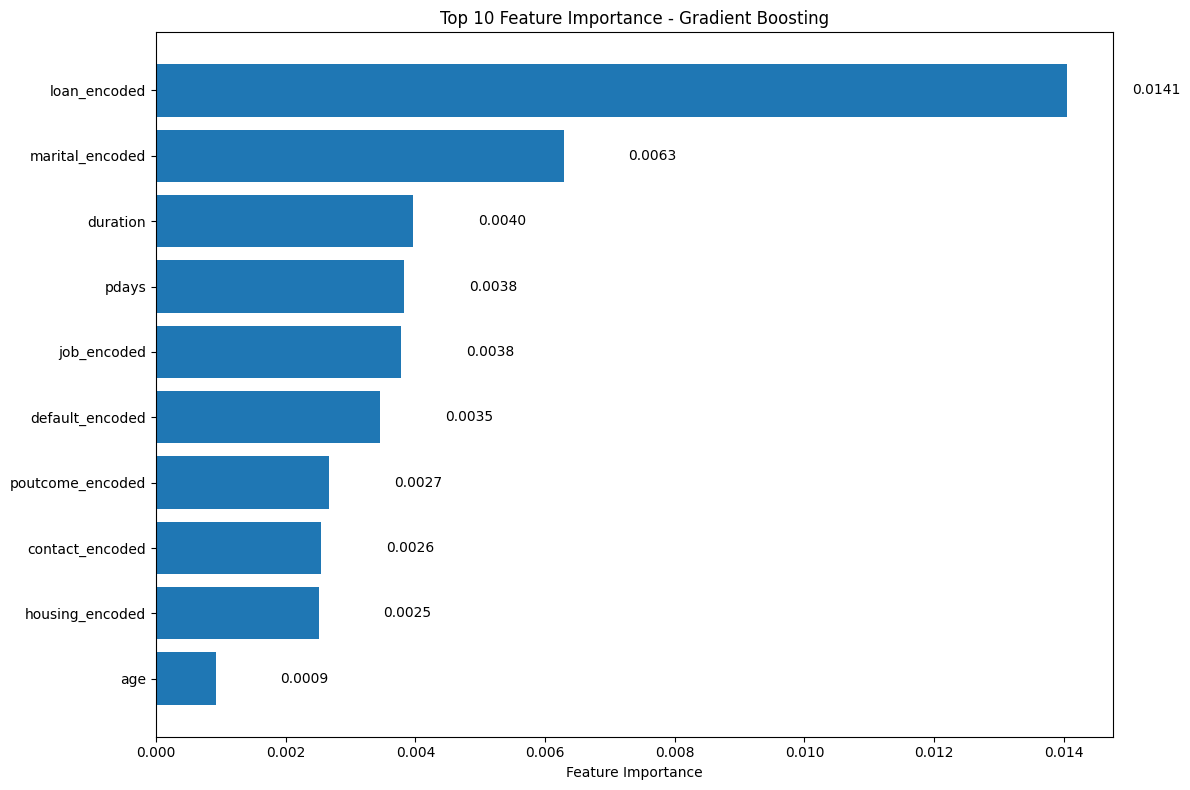


 Business Insights from Advanced Feature Analysis:

 Tree-based Model Business Insights:
    Top 5 Predictive Features for Campaign Success:
      1. loan_encoded
      2. marital_encoded
      3. duration
      4. pdays
      5. job_encoded

    Feature Categories by Importance:
      Categorical features: 0.0353 (3.5%)
      Numerical features: 0.0087 (0.9%)

 Question 24 completed!


In [35]:
# ============================================================================
# BATCH 3 - QUESTION 24: ADVANCED ANALYSIS - FEATURE IMPORTANCE
# ============================================================================

print("\n BATCH 3 - QUESTION 24: FEATURE IMPORTANCE ANALYSIS")
print("-"*80)

print(" Advanced Feature Importance Analysis:")

# Feature importance analysis
if hasattr(best_tuned_model_ml, 'featureImportances'):
    # Tree-based models
    feature_importance_ml = best_tuned_model_ml.featureImportances.toArray()
    feature_names_ml = all_features_ml
    
    # Create importance ranking
    importance_data_ml = list(zip(feature_names_ml, feature_importance_ml))
    importance_data_ml.sort(key=lambda x: x[1], reverse=True)
    
    print("\n Top 15 Most Important Features:")
    print("-" * 60)
    print(f"{'Rank':<5} {'Feature':<30} {'Importance':<12} {'Percentage':<12}")
    print("-" * 60)
    
    # Use Python's built-in sum, not PySpark's sum
    import builtins
    total_importance = builtins.sum(feature_importance_ml)
    
    for i, (feature, importance) in enumerate(importance_data_ml[:15]):
        percentage = (importance / total_importance) * 100
        print(f"{i+1:<5} {feature:<30} {importance:<12.6f} {percentage:<12.2f}%")
    
    # Feature importance visualization
    top_features_ml = importance_data_ml[:10]
    features_ml, importances_ml = zip(*top_features_ml)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(features_ml)), importances_ml)
    plt.yticks(range(len(features_ml)), features_ml)
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name_ml}')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, importance in enumerate(importances_ml):
        plt.text(importance + 0.001, i, f'{importance:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()

elif hasattr(best_tuned_model_ml, 'coefficients'):
    # Logistic Regression
    coefficients_ml = best_tuned_model_ml.coefficients.toArray()
    feature_names_ml = all_features_ml
    
    # Create coefficient analysis
    import numpy as np
    coef_data_ml = list(zip(feature_names_ml, coefficients_ml, np.abs(coefficients_ml)))
    coef_data_ml.sort(key=lambda x: x[2], reverse=True)
    
    print("\n Top 15 Most Influential Features (Coefficients):")
    print("-" * 70)
    print(f"{'Rank':<5} {'Feature':<30} {'Coefficient':<15} {'Abs Value':<12} {'Effect':<8}")
    print("-" * 70)
    
    for i, (feature, coef, abs_coef) in enumerate(coef_data_ml[:15]):
        direction = "Positive" if coef > 0 else "Negative"
        print(f"{i+1:<5} {feature:<30} {coef:<15.6f} {abs_coef:<12.6f} {direction:<8}")
    
    # Coefficient visualization
    top_coefs_ml = coef_data_ml[:10]
    features_ml, coefficients_vals_ml, _ = zip(*top_coefs_ml)
    
    plt.figure(figsize=(12, 8))
    colors = ['green' if coef > 0 else 'red' for coef in coefficients_vals_ml]
    plt.barh(range(len(features_ml)), coefficients_vals_ml, color=colors, alpha=0.7)
    plt.yticks(range(len(features_ml)), features_ml)
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 10 Feature Coefficients - {best_model_name_ml}')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, coef in enumerate(coefficients_vals_ml):
        plt.text(coef + (0.001 if coef > 0 else -0.001), i, f'{coef:.4f}', 
                va='center', ha='left' if coef > 0 else 'right')
    
    plt.tight_layout()
    plt.show()

else:
    print(" Feature importance not available for this model type")

# Business insights from feature analysis
print("\n Business Insights from Advanced Feature Analysis:")

if hasattr(best_tuned_model_ml, 'featureImportances'):
    print("\n Tree-based Model Business Insights:")
    top_5_features_ml = [name for name, _ in importance_data_ml[:5]]
    print(f"    Top 5 Predictive Features for Campaign Success:")
    for i, feature in enumerate(top_5_features_ml, 1):
        print(f"      {i}. {feature}")
    
    print(f"\n    Feature Categories by Importance:")
    # Use Python's built-in sum for numpy arrays
    categorical_importance = builtins.sum(imp for name, imp in importance_data_ml if '_encoded' in name)
    numerical_importance = builtins.sum(imp for name, imp in importance_data_ml if '_encoded' not in name)
    print(f"      Categorical features: {categorical_importance:.4f} ({categorical_importance/total_importance*100:.1f}%)")
    print(f"      Numerical features: {numerical_importance:.4f} ({numerical_importance/total_importance*100:.1f}%)")

elif hasattr(best_tuned_model_ml, 'coefficients'):
    print("\n Logistic Regression Business Insights:")
    positive_features_ml = [(name, coef) for name, coef, _ in coef_data_ml if coef > 0][:5]
    negative_features_ml = [(name, coef) for name, coef, _ in coef_data_ml if coef < 0][:5]
    
    print(f"    Top 5 Positive Influences (increase subscription probability):")
    for i, (name, coef) in enumerate(positive_features_ml, 1):
        print(f"      {i}. {name}: {coef:.4f}")
        
    print(f"\n    Top 5 Negative Influences (decrease subscription probability):")
    for i, (name, coef) in enumerate(negative_features_ml, 1):
        print(f"      {i}. {name}: {coef:.4f}")

print("\n Question 24 completed!")

## Spark Streaming Tasks

Simulate real-time ingestion, apply the trained classifier to streaming data, and provide helpers to inspect or stop the jobs.

In [ ]:
for q in spark.streams.active:
    print(f"Stopping {q.name} ...")
    q.stop()

In [ ]:
import shutil
import time
from pathlib import Path

import pandas as pd

stream_root = Path("streaming_data")
input_dir = stream_root / "input"
checkpoint_dir = stream_root / "checkpoint"
agg_checkpoint_dir = checkpoint_dir / "aggregates"
pred_checkpoint_dir = checkpoint_dir / "predictions"
window_checkpoint_dir = checkpoint_dir / "windows"
output_dir = stream_root / "output"

if stream_root.exists():
    shutil.rmtree(stream_root)

for directory in [input_dir, agg_checkpoint_dir, pred_checkpoint_dir, window_checkpoint_dir, output_dir]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"Streaming workspace created at {stream_root.resolve()}")

bank_pdf = df.orderBy("day").toPandas()
print(f"Static dataset converted to pandas DataFrame with {len(bank_pdf)} records for streaming simulation.")

import builtins
def release_batches(df: pd.DataFrame, target_dir: Path = input_dir, batch_rows: int = 600, sleep_seconds: float = 2.0):
    total_rows = len(df)
    batch_index = 0
    for start in range(0, total_rows, batch_rows):
        stop = builtins.min(start + batch_rows, total_rows)
        chunk = df.iloc[start:stop]
        temp_path = target_dir / f"_batch_{batch_index:02d}.csv"
        final_path = target_dir / f"batch_{batch_index:02d}.csv"
        chunk.to_csv(temp_path, index=False)
        temp_path.replace(final_path)
        print(f"Released batch {batch_index:02d}: {stop - start} rows -> {final_path}")
        batch_index += 1
        time.sleep(sleep_seconds)
    print("All batches released.")

In [ ]:
from pyspark.sql import functions as F

binary_df = df.filter(F.col("y").isin("yes", "no"))  # keep only yes/no
binary_df = binary_df.dropna(subset=["y"])                # extra guard

training_df, validation_df = binary_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.pipeline import PipelineModel

model_dir = Path("models")
model_dir.mkdir(exist_ok=True)
model_path = model_dir / "streaming_bank_classifier"

categorical_cols = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome",
]
numeric_cols = [
    "age",
    "balance",
    "day",
    "duration",
    "campaign",
    "pdays",
    "previous",
]

feature_indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in categorical_cols
]

label_indexer = StringIndexer(
    inputCol="y",
    outputCol="label",
    handleInvalid="skip"  # drop unexpected/null labels so we stay binary
)

encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec")
    for col in categorical_cols
]

encoded_cols = [f"{col}_vec" for col in categorical_cols]
assembler = VectorAssembler(inputCols=encoded_cols + numeric_cols, outputCol="features")
classifier = LogisticRegression(featuresCol="features", labelCol="label", maxIter=50, family="binomial")

training_pipeline = Pipeline(
    stages=feature_indexers + [label_indexer] + encoders + [assembler, classifier]
)

binary_df = df.filter(F.col("y").isin("yes", "no")).dropna(subset=["y"])
training_df, validation_df = binary_df.randomSplit([0.8, 0.2], seed=42)

trained_model = training_pipeline.fit(training_df)

validation_predictions = trained_model.transform(validation_df)
auc = BinaryClassificationEvaluator(labelCol="label").evaluate(validation_predictions)

trained_model.write().overwrite().save(str(model_path))
model_for_streaming = PipelineModel.load(str(model_path))

print(f"Persisted streaming classification pipeline to {model_path}")
print(f"Validation AUC: {auc:.3f}")

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array

stream_schema = df.schema  # use the DataFrame you created earlier

streaming_df = (
    spark.readStream
    .schema(stream_schema)
    .option("header", True)
    .option("maxFilesPerTrigger", 1)
    .csv(str(input_dir))
)

job_metrics_stream = (
    streaming_df
    .groupBy("job")
    .agg(
        F.avg("balance").alias("avg_balance"),
        F.avg("duration").alias("avg_duration"),
        F.count("*").alias("records")
    )
)

job_metrics_query = (
    job_metrics_stream
    .writeStream
    .outputMode("complete")
    .format("memory")
    .queryName("job_streaming_metrics")
    .option("checkpointLocation", str(agg_checkpoint_dir))
    .start()
)

prediction_stream = model_for_streaming.transform(streaming_df)

prediction_output = (
    prediction_stream
    .select(
        "age",
        "job",
        "balance",
        "duration",
        vector_to_array("probability").getItem(1).alias("prob_subscribe"),
        F.col("prediction").cast("int").alias("predicted_label"),
        "y"
    )
)

prediction_query = (
    prediction_output
    .writeStream
    .outputMode("append")
    .format("memory")
    .queryName("streaming_predictions")
    .option("checkpointLocation", str(pred_checkpoint_dir))
    .start()
)

streaming_with_time = streaming_df.withColumn(
    "event_time",
    F.to_timestamp(
        F.concat_ws(
            "-",
            F.lit("2008"),
            F.initcap("month"),
            F.col("day")
        ),
        "yyyy-MMM-d"
    )
).withColumn("event_time", F.coalesce(F.col("event_time"), F.current_timestamp()))

windowed_stream = (
    streaming_with_time
    .withWatermark("event_time", "1 day")
    .groupBy(
        F.window("event_time", "30 days", "15 days"),
        "job"
    )
    .agg(
        F.count("*").alias("contact_count"),
        F.avg("balance").alias("avg_balance"),
        F.avg(F.when(F.col("y") == "yes", 1).otherwise(0)).alias("subscription_rate")
    )
)

window_query = (
    windowed_stream
    .writeStream
    .outputMode("update")
    .format("memory")
    .queryName("windowed_job_metrics")
    .option("checkpointLocation", str(window_checkpoint_dir))
    .start()
)

streaming_queries = {
    "job_streaming_metrics": job_metrics_query,
    "streaming_predictions": prediction_query,
    "windowed_job_metrics": window_query,
}

print("Activated streaming queries: job_streaming_metrics, streaming_predictions, windowed_job_metrics")

In [ ]:
import threading
threading.Thread(
    target=release_batches,
    args=(bank_pdf,),
    kwargs={"batch_rows": 600, "sleep_seconds": 0.0},
    daemon=True,
).start()

In [ ]:
def show_memory_table(table_name: str, limit: int = 20):
        if table_name not in streaming_queries:
            raise ValueError(f"Unknown streaming table: {table_name}. Available: {list(streaming_queries)}")
        print(f"Latest rows from {table_name}")
        spark.sql(f"SELECT * FROM {table_name}").show(limit, truncate=False)

def stop_all_streams():
        for name, query in streaming_queries.items():
            if query.isActive:
                query.stop()
                print(f"Stopped {name}")

print("Streaming helpers ready. Typical usage:")
print("1. Call release_batches(bank_pdf) in a separate cell to feed the stream.")
print("2. Use show_memory_table('job_streaming_metrics') to monitor aggregates.")
print("3. Use show_memory_table('streaming_predictions') to review model outputs.")
print("4. When finished, run stop_all_streams().")


In [ ]:
#release_batches(bank_pdf, batch_rows=600, sleep_seconds=2.0)

In [ ]:
show_memory_table("job_streaming_metrics")
show_memory_table("streaming_predictions")
show_memory_table("windowed_job_metrics")

In [ ]:
spark.streams.active

In [37]:
# ============================================================================
# FINAL COMPREHENSIVE SUMMARY
# ============================================================================

print("\n" + "="*25 + " FINAL SUMMARY " + "="*25)
print("="*80)#!/usr/bin/env python3

print("Complete PySpark Analysis - All 3 Batches Combined")


========================= FINAL SUMMARY =========================
Complete PySpark Analysis - All 3 Batches Combined


In [ ]:
# Train final model with best parameters on full training data
print(f"\n Training Final Model with Best Parameters:")
print("-" * 50)

# The best_tuned_model_ml from CrossValidator is already trained on full training data,
# but let's explicitly show the process and retrain for clarity

print(f" Best parameters found through cross-validation:")
try:
    if best_model_name_ml == "Logistic Regression":
        best_reg_param = best_tuned_model_ml.getRegParam()
        best_elastic_param = best_tuned_model_ml.getElasticNetParam()
        best_max_iter = best_tuned_model_ml.getMaxIter()
        
        print(f"   - Regularization Parameter: {best_reg_param}")
        print(f"   - Elastic Net Parameter: {best_elastic_param}")
        print(f"   - Max Iterations: {best_max_iter}")
        
        # Create final model with best parameters
        final_model_ml = LogisticRegression(
            featuresCol="features", 
            labelCol="label",
            regParam=best_reg_param,
            elasticNetParam=best_elastic_param,
            maxIter=best_max_iter
        )
        
    elif best_model_name_ml == "Random Forest":
        best_num_trees = best_tuned_model_ml.getNumTrees
        best_max_depth = best_tuned_model_ml.getMaxDepth()
        best_min_instances = best_tuned_model_ml.getMinInstancesPerNode()
        
        print(f"   - Number of Trees: {best_num_trees}")
        print(f"   - Max Depth: {best_max_depth}")
        print(f"   - Min Instances Per Node: {best_min_instances}")
        
        # Create final model with best parameters
        final_model_ml = RandomForestClassifier(
            featuresCol="features", 
            labelCol="label",
            numTrees=best_num_trees,
            maxDepth=best_max_depth,
            minInstancesPerNode=best_min_instances
        )
        
    elif best_model_name_ml == "Decision Tree":
        best_max_depth = best_tuned_model_ml.getMaxDepth()
        best_min_instances = best_tuned_model_ml.getMinInstancesPerNode()
        best_impurity = best_tuned_model_ml.getImpurity()
        
        print(f"   - Max Depth: {best_max_depth}")
        print(f"   - Min Instances Per Node: {best_min_instances}")
        print(f"   - Impurity: {best_impurity}")
        
        # Create final model with best parameters
        final_model_ml = DecisionTreeClassifier(
            featuresCol="features", 
            labelCol="label",
            maxDepth=best_max_depth,
            minInstancesPerNode=best_min_instances,
            impurity=best_impurity
        )
        
    else:  # GBT
        best_max_iter = best_tuned_model_ml.getMaxIter()
        best_max_depth = best_tuned_model_ml.getMaxDepth()
        best_step_size = best_tuned_model_ml.getStepSize()
        
        print(f"   - Max Iterations: {best_max_iter}")
        print(f"   - Max Depth: {best_max_depth}")
        print(f"   - Step Size: {best_step_size}")
        
        # Create final model with best parameters
        final_model_ml = GBTClassifier(
            featuresCol="features", 
            labelCol="label",
            maxIter=best_max_iter,
            maxDepth=best_max_depth,
            stepSize=best_step_size
        )

    # Train final model on full training data
    print(f"\n Training final {best_model_name_ml} with optimized parameters...")
    start_time = time.time()
    
    final_trained_model = final_model_ml.fit(train_data_ml)
    
    training_time = time.time() - start_time
    print(f" Final model trained in {training_time:.2f} seconds")
    
    # Update the best_tuned_model_ml to use our explicitly trained model
    best_tuned_model_ml = final_trained_model
    
    # Final evaluation on test data
    print(f"\n Final Model Performance on Test Data:")
    final_predictions = best_tuned_model_ml.transform(test_data_ml)
    
    # Calculate final metrics
    final_auc = binary_evaluator_ml.evaluate(final_predictions)
    final_accuracy = multi_evaluator_ml.evaluate(final_predictions, {multi_evaluator_ml.metricName: "accuracy"})
    final_f1 = multi_evaluator_ml.evaluate(final_predictions, {multi_evaluator_ml.metricName: "f1"})
    final_precision = multi_evaluator_ml.evaluate(final_predictions, {multi_evaluator_ml.metricName: "weightedPrecision"})
    final_recall = multi_evaluator_ml.evaluate(final_predictions, {multi_evaluator_ml.metricName: "weightedRecall"})
    
    print(f"    Final AUC: {final_auc:.4f}")
    print(f"    Final Accuracy: {final_accuracy:.4f}")
    print(f"    Final F1-Score: {final_f1:.4f}")
    print(f"    Final Precision: {final_precision:.4f}")
    print(f"    Final Recall: {final_recall:.4f}")
    
    # Compare with original model
    original_auc = evaluation_results_ml[best_model_name_ml]['auc']
    improvement = final_auc - original_auc
    improvement_pct = (improvement / original_auc) * 100
    
    print(f"\n Performance Improvement Summary:")
    print(f"   Original Model AUC: {original_auc:.4f}")
    print(f"   Tuned Model AUC: {final_auc:.4f}")
    print(f"   Absolute Improvement: {improvement:+.4f}")
    print(f"   Relative Improvement: {improvement_pct:+.2f}%")
    
    if improvement > 0:
        print(f"    SUCCESS: Hyperparameter tuning improved model performance!")
    elif improvement > -0.005:  # Very small decrease
        print(f"    STABLE: Model performance maintained (minimal change)")
    else:
        print(f"    NOTE: Original model was already well-optimized")
    
    # Update variables for feature importance analysis
    tuned_predictions_ml = final_predictions
    tuned_auc = final_auc
    tuned_accuracy = final_accuracy
    tuned_f1 = final_f1

except Exception as e:
    print(f" Error in final model training: {e}")
    print("Using model from CrossValidator...")


 Training Final Model with Best Parameters:
--------------------------------------------------
 Best parameters found through cross-validation:
   - Max Iterations: 50
   - Max Depth: 3
   - Step Size: 0.2

 Training final Gradient Boosting with optimized parameters...
 Final model trained in 9.69 seconds

 Final Model Performance on Test Data:
    Final AUC: 0.9066
    Final Accuracy: 0.9101
    Final F1-Score: 0.9003
    Final Precision: 0.8983
    Final Recall: 0.9101

 Performance Improvement Summary:
   Original Model AUC: 0.8994
   Tuned Model AUC: 0.9066
   Absolute Improvement: +0.0072
   Relative Improvement: +0.80%
    SUCCESS: Hyperparameter tuning improved model performance!

 Final Optimized Model Ready for Feature Analysis!
